# Projekt 02 - MSP
- Jakub Kratochvíl (xkrato67)

## Věrohodnost

### 1)
- Zvolená parametrizace:
Zvolil jsem klasickou variantu weibullova rozdělení, které je definováno následovně:
$$
f(\lambda, k) =
\begin{cases} 
\frac{k}{\lambda} \left( \frac{x}{\lambda} \right)^{k-1} e^{-\left( \frac{x}{\lambda} \right)^k}, & x \geq 0, \\
0, & x < 0.
\end{cases}
$$

- Logaritmická věrohodnostní funkce s cenzorovanými daty:
$$
\begin{align*}
\ell(k, \lambda, \delta) = \sum_{i=1}^n \delta_i \left( \ln\left(\frac{k}{\lambda}\right) + (k-1)\ln\left(\frac{x_i}{\lambda}\right) - \left(\frac{x_i}{\lambda}\right)^k \right) + \sum_{i=1}^n (1 - \delta_i) \left(-\left(\frac{x_i}{\lambda}\right)^k \right)
\end{align*}
$$

- Parciální derivace podle k a $\lambda$:
$$
\frac{\partial \ell}{\partial k} = \sum_{i=1}^n \left[ \delta_i \left( \frac{1}{k} + \ln\left(\frac{x_i}{\lambda}\right) - \left(\frac{x_i}{\lambda}\right)^k \ln\left(\frac{x_i}{\lambda}\right) \right) - (1 - \delta_i) \left(\frac{x_i}{\lambda}\right)^k \ln\left(\frac{x_i}{\lambda}\right) \right] = \sum_{i=1}^n \delta_i \left( \frac{1}{k} + \ln\left(\frac{x_i}{\lambda}\right) \right) - \sum_{i=1}^n \left(\frac{x_i}{\lambda}\right)^k \ln\left(\frac{x_i}{\lambda}\right)
$$

$$
\frac{\partial \ell}{\partial \lambda} = \sum_{i=1}^n \delta_i \left( -\frac{1}{\lambda} - \frac{k-1}{\lambda} + \frac{kx_{i}^k}{\lambda^{k+1}} \right) + \sum_{i=1}^n (1-\delta_i)\frac{kx_i^k}{\lambda^{k+1}} = \sum_{i=1}^n \delta_i \left( -\frac{1}{\lambda} - \frac{k-1}{\lambda} \right) + \frac{kx_{i}^k}{\lambda^{k+1}} = \sum_{i=1}^n \frac{k}{\lambda} \left( -\delta_i + \left(\frac{x_i}{\lambda}\right)^k \right)
$$

In [581]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import scipy.special as special

# Načtení dat z Excelu
df = pd.read_excel('Data_2024.xlsx', sheet_name='Data_věrohodnost')

# Extrakce potřebných sloupců
times = df['doba práce v oboru [roky]'].values
censored = df['censored'].values.astype(bool)

In [582]:
def weibull_log_likelihood(params, times, censored):
    k, lam = params 
    t_per_l = times / lam
    pdf = k/lam * (t_per_l)**(k-1) * np.exp(-(t_per_l)**k)
    # Survival funkce (1 - CDF) pro cenzorovaná data
    survival_func = 1 - (1 - np.exp(-(t_per_l)**k))
    log_likelihood = np.sum(
        np.log(pdf) * ~censored + np.log(survival_func) * censored
    )
    return -log_likelihood

def get_mle(data_tuple):
    initial = [6.0, 7.0]
    result = minimize(
        weibull_log_likelihood, 
        initial, 
        args=data_tuple, 
        method='Nelder-Mead'
    )
    # Výsledné parametry
    shape_param, scale_param = result.x
    print(f"Maximálně věrohodné odhady:")
    print(f"\tShape (k): {shape_param:.4f}")
    print(f"\tScale (λ): {scale_param:.4f}")
    return shape_param, scale_param

shape, scale = get_mle((times, censored))

Maximálně věrohodné odhady:
	Shape (k): 6.1728
	Scale (λ): 7.4295


### 2)
- MLE pro parametr Shape (k) vyšel: 6.1728
- MLE pro parametr Scale (λ) vyšel: 7.4295

In [583]:
def likelihood_ratio_test(data_tuple, parameter_tuple):
    def constrained_likelihood(params):
        return weibull_log_likelihood([1.0, params[0]], data_tuple[0], data_tuple[1])
    
    constrained_result = minimize(
        constrained_likelihood,
        [parameter_tuple[0]],
        method='Nelder-Mead'
    )
    
    # Log-likelihood pro plný model
    full_log_likelihood = -weibull_log_likelihood(parameter_tuple, data_tuple[0], data_tuple[1])
    constrained_log_likelihood = -constrained_result.fun

    # Likelihood ratio test statistic
    lr_statistic = 2 * (full_log_likelihood - constrained_log_likelihood)
    # Kritická hodnota pro 5% hladinu významnosti (1 stupeň volnosti)
    critical_value = stats.chi2.ppf(0.99, df=1)
    
    print("Likelihood Ratio Test:")
    print(f"\tTest statistic: {lr_statistic:.4f}")
    print(f"\tCritical value (1%): {critical_value:.4f}")
    print(f"\tZamítáme nulovou hypotézu: {'Ano' if lr_statistic > critical_value else 'Ne'}")

# Zavoláme metody pro vypsání hodnot
likelihood_ratio_test((times, censored), (shape, scale))

Likelihood Ratio Test:
	Test statistic: 592.3898
	Critical value (1%): 6.6349
	Zamítáme nulovou hypotézu: Ano


### 3)
$H_0$: Omezený model je dostatečný

$H_1$: Plný model poskytuje lepší výsledek

Nulovou hypotézu zamítame, tedy s 99% pravděpodobností platí alternativní hypotéza - Plný model poskytuje lepší výsledek.

In [584]:
def weibull_point_estimates(parameters):
    shape = parameters[0]
    scale = parameters[1]
    # Střední doba zaměstnání
    mean_time = scale * special.gamma(1 + 1/shape)
    # 10% percentil
    percentile_10 = scale * (-np.log(0.9)) ** (1/shape)
    print("Charakteristiky:")
    print(f"\tStřední doba zaměstnání v oboru: {mean_time:.4f} let")
    print(f"\t10% percentil doby zaměstnání: {percentile_10:.4f} let")

weibull_point_estimates((shape,scale))

Charakteristiky:
	Střední doba zaměstnání v oboru: 6.9033 let
	10% percentil doby zaměstnání: 5.1598 let


### 4)
Střední doba zaměstnání v oboru vychází: 6.9033 let

10% percentil doby zaměstnání vychází: 5.1598 let

## Regrese

1. Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí „plný“ model považujte
plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které
dávají smysl).
    - Zapište rovnici Vašeho finálního modelu.
    - Diskutujte splnění předpokladů lineární regrese a základní regresní diagnostiky.
    - Pokud (až během regresního modelování) identifikujete některé „extrémně odlehlé
hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém zdůvodnění,
vyřadit.
2. Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva
nejproblematičtější (největší) hodnotu (použijte model, nikoli samotná pozorování).
3. Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních
parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.
4. Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model „vhodný“
pro další použit


#### 1) 

In [585]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Načtení dat z Excelu
df = pd.read_excel('Data_2024.xlsx', sheet_name='Data_regrese')
# Přejmenování, zejména kvůli formátu formule v smf.ols
df = df.rename(columns={
    'Ping [ms]'         : 'Ping',
    'InteractingPct'    : 'Interact',
    'ScrollingPct'      : 'Scroll',
})
# Přetypování OSType na categorical, jelikož máme jen 4 různé hodnoty
df['OSType'] = df['OSType'].astype('category')
# Z prvního pohledu na data vidíme, že procenta interakce a skrolování
# jsou sobě doplňkem, takže jeden z těchto sloupců pro regresní model
# nepotřebujeme. Odebereme třeba procenta interakce.
df = df.drop(columns=['Interact'])
df

,OSType,ActiveUsers,Scroll,Ping
0,iOS,4113,0.1717,47
1,iOS,7549,0.6539,46
2,Windows,8855,0.7822,55
3,Android,8870,0.9206,56
4,MacOS,9559,0.2718,76
...,...,...,...,...
497,iOS,5315,0.8026,28
498,MacOS,1392,0.7627,24
499,iOS,6014,0.1888,54
500,Android,5118,0.7655,39


Nyní máme data připravená a můžeme vytvořit výchozí model. Jelikož nás v druhé otázce zajímá odezva (Ping), budeme v modelu vyjadřovat právě odezvu. Výchozí model bude definován následovně:

$$
\begin{align*}
Ping &= \beta_{1} + \beta_{2} * ActiveUsers + \beta_{3} * Scroll + \beta_{4} * Windows + \beta_{5} * MacOS + \beta_{6} * iOS\\
&+ \beta_{7} * (ActiveUsers*Scroll) + \beta_{8} * (ActiveUsers*Windows) + \beta_{9} * (ActiveUsers*MacOS)\\
&+ \beta_{10} * (ActiveUsers*iOS) + \beta_{11} * ActiveUsers^2 + \beta_{12} * (Scroll*Windows) + \beta_{13} * (Scroll*MacOS)\\
&+ \beta_{14} * (Scroll*iOS) + \beta_{15} * Scroll^2
\end{align*}
$$

Nyní si model vytvoříme v kódu, kde to bude lehce ulehčené díky použití OSType jako kategoriálního typu, který nám zajistí rozepsání jednotlivých kategorií za nás, použitím C(OSType). Toto za nás dosadí dummies a také zajistí správnou multikolinearitu kategorických proměnných vynecháním jedné kategorie. Také ale zkontrolujeme multikolinearitu jednotlivých parametrů a případně provedeme standardizaci.

In [586]:
f = "Ping ~ ActiveUsers + Scroll + C(OSType) + ActiveUsers:Scroll + ActiveUsers:C(OSType) + I(ActiveUsers**2) + Scroll:C(OSType) + I(Scroll**2)"
model = smf.ols(formula=f, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        03:33:38   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Vidíme, že dostáváme přímo upozornění na silnou multikolinearitu, což nám říká že bysme měli použít nějakou standardizaci. Tu tedy provedeme v následujícím kroku.

In [587]:
# VIF aktuálních dat
print("VIF dat před standardizací")
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()
vif_df.columns = ['VIF']
print(vif_df)

# VIF standardizovaného modelu pomocí z-value
print("\nVIF dat po standardizací")
dfs = df.copy()

# Uložíme si střední hodnoty a směrodatné hodnoty
# jelikož je budeme potřebovat později
au_mean = dfs['ActiveUsers'].mean()
au_std = dfs['ActiveUsers'].std()
dfs['ActiveUsers'] = (dfs['ActiveUsers'] - au_mean) / au_std

sc_mean = dfs['Scroll'].mean()
sc_std = dfs['Scroll'].std()
dfs['Scroll'] = (dfs['Scroll'] - sc_mean) / sc_std

model = smf.ols(formula=f, data=dfs)
results = model.fit()

X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()
vif_df.columns = ['VIF']
print(vif_df)

VIF dat před standardizací
                                        VIF
Intercept                         91.854488
C(OSType)[T.MacOS]                15.217934
C(OSType)[T.Windows]              16.447197
C(OSType)[T.iOS]                  14.840501
ActiveUsers                       32.087036
ActiveUsers:C(OSType)[T.MacOS]    10.454073
ActiveUsers:C(OSType)[T.Windows]  10.189613
ActiveUsers:C(OSType)[T.iOS]       9.061267
Scroll                            25.577021
Scroll:C(OSType)[T.MacOS]          6.489601
Scroll:C(OSType)[T.Windows]        7.671741
Scroll:C(OSType)[T.iOS]            7.692924
ActiveUsers:Scroll                 8.705628
I(ActiveUsers ** 2)               22.499134
I(Scroll ** 2)                    16.422293

VIF dat po standardizací
                                       VIF
Intercept                         6.781856
C(OSType)[T.MacOS]                1.654677
C(OSType)[T.Windows]              1.630480
C(OSType)[T.iOS]                  1.606613
ActiveUsers                 

Po standardizaci sloupců ActiveUsers a Scroll jsou aktuální hodnoty VIF menší než hodnota 10, což už bereme jako přijatelné hodnoty míry multikolinearity.

Při následném dosazování hodnot nesmíme ale zapomenout nové hodnoty buď standardizovat anebo navrátit podel do původního tvaru.

Jelikož máme připravený výchozí model, můžeme konečně provést zpětnou eliminaci, která funguje následovně:
1. Začneme se všemi přomennými v modelu
2. Odebereme proměnnou s největší p-hodnotou
3. Použijeme aktualizováný model a vracíme se do bodu 2 až do nějaké zastavovací podmínky,
   např. kdy všechny proměnné mají p-hodnotu pod nějakým prahem

Tím, že odstraníme hodnoty s největšími p-hodnotami tak odebereme statisticky nezávislé proměnné.

Začal jsem tedy s implementací zpětné eliminace, ovšem po napsání jakéhosi prototypu mi došlo, že nedokážu odstanit z řetezce formule specifickou kategorii, jelikož ty se automaticky rozbalují z C(OSType).

A jelikož se mi už něchtělo upravovat dataframe a dělat si vlastní kategorie našel jsem workaround a to takový, že přímo upravuji matici, kde odstraňuji nežádoucí kategorie nebo interakce.

Zpětnou eliminaci implementuje následující blok kódu:

In [588]:
import patsy as pat
# Funkce pro úpravu modelu pomocí modifikace matice
def remove_from_matrix(formula, dataframe, remove_str, columns_to_drop_prev):
    y, X = pat.dmatrices(formula, data=dataframe, return_type='dataframe')
    
    if isinstance(remove_str, tuple):
        new_columns_to_drop = [col for col in X.columns if all(r in col for r in remove_str)]
    else:
        new_columns_to_drop = [col for col in X.columns if remove_str in col]
    
    columns_to_drop = list(set(columns_to_drop_prev + new_columns_to_drop))
    X_modified = X.drop(columns=columns_to_drop)
    model = sm.OLS(y, X_modified)
    return model, columns_to_drop


# Pomocná funkce pro ziskání proměnných v intersekci
def parse_interaction(s):
    return s if ":" not in s else s.split(':')[0], s.split('[T.')[-1].strip(']')


# Výchozí standardizováný model je uložen v proměnné model a fit() v result
p_values = results.pvalues
max_value = p_values[p_values.idxmax()]
s1,s2 = parse_interaction(p_values.idxmax())
print("Variable with the highest p-value is: ", s1+":"+s2, max_value)
new_cols = []

# Loop který provádí zpětnou eliminaci a vypisuje odstraňované proměnné
while max_value > 0.05:
    model, new_cols = remove_from_matrix(f, dfs, parse_interaction(p_values.idxmax()), new_cols)
    results = model.fit()
    p_values = results.pvalues
    max_value = p_values[p_values.idxmax()]
    s1,s2 = parse_interaction(p_values.idxmax())
    print("Variable with the highest p-value is: ", s1+":"+s2, max_value)

print("\nFinal model:")
results_final = results
print(results_final.summary())

Variable with the highest p-value is:  Scroll:iOS 0.920766522138589
Variable with the highest p-value is:  Scroll:Windows 0.9023977373454168
Variable with the highest p-value is:  Scroll:MacOS 0.760220507487699
Variable with the highest p-value is:  I(Scroll ** 2):I(Scroll ** 2) 0.27753223057943377
Variable with the highest p-value is:  ActiveUsers:Windows 0.014940511032521005

Final model:
                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        03:33:38   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:         

Nalezli jsme tedy náš výsledný model pomocí zpětné eliminace. Rovnice modelu tedy vypadá následovně:
$$
\begin{align*}
Ping &= \beta_{1} + \beta_{2} * ActiveUsers + \beta_{3} * Scroll + \beta_{4} * Windows + \beta_{5} * MacOS + \beta_{6} * iOS \beta_{7} * (ActiveUsers*Scroll)\\
&+ \beta_{8} * (ActiveUsers*Windows) + \beta_{9} * (ActiveUsers*MacOS) + \beta_{10} * (ActiveUsers*iOS) + \beta_{11} * ActiveUsers^2
\end{align*}
$$

Dalším úkolem je odstranit odlehlé hodnoty. Ideálně bychom to měli provést už před standardizací, ale vzhledem k tomu, že jsme doposud nevěděli, jak bude náš model vypadat, je stále dobré to udělat alespoň nyní. Data si zobrazíme do grafů.

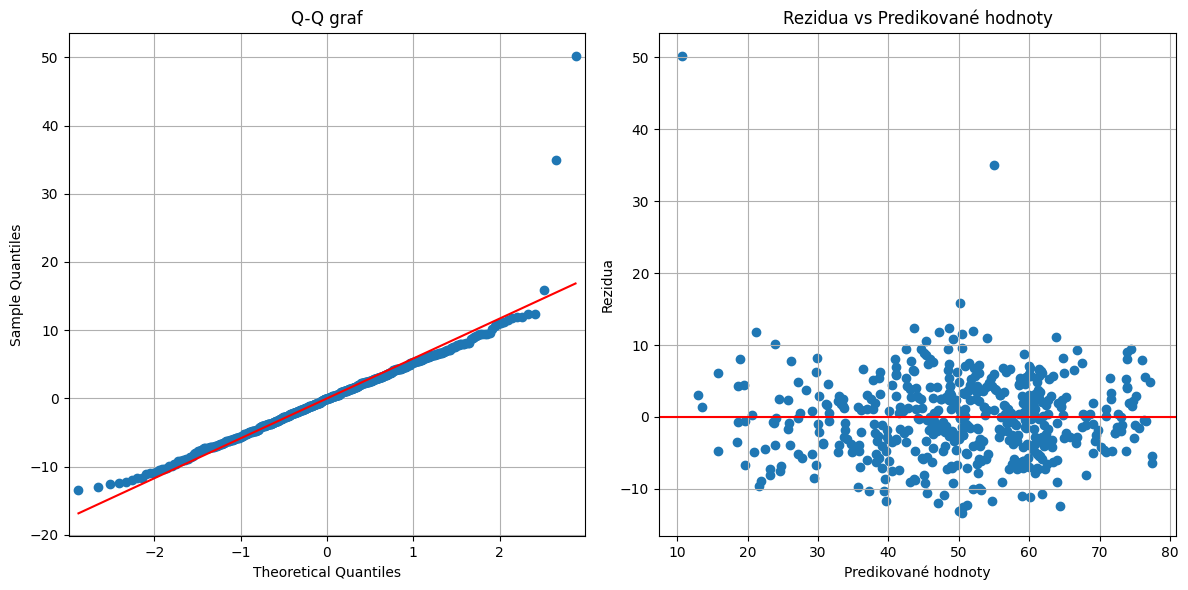

In [589]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
qqplot(results_final.resid, line='s', ax=ax[0])
ax[0].set_title('Q-Q graf')
ax[0].grid(True)
ax[1].scatter(results_final.fittedvalues, results_final.resid)
ax[1].axhline(y=0, color='r', linestyle='-')
ax[1].grid(True)
ax[1].set_xlabel('Predikované hodnoty')
ax[1].set_ylabel('Rezidua')
ax[1].set_title('Rezidua vs Predikované hodnoty')
plt.tight_layout()
plt.show()

Z grafů můžeme vidět, že mám dvě odlehlé hodnoty, které se velice odchylují od predikovaných (normálních) hodnot. Tyto dvě hodnoty můžeme z modelu dostat pomocí Cookovu vzdáleností a nastavení vhodného prahu, tak abychom smazal pouze tyto dvě hodnoty.

Ovšem je vždycky dobré mít nějaký hlubší důvod pro odebrání dat než pouze test nebo odhad. V tomto případě bych to odůvodnil tak, že máme docela velký počet pozorování a vychýlení je opravdu značné, proto si myslím že to je v tomto případě validní.

Jako vhodný práh se zdá 15 / počet pozorování. Jelikož dostáváme pouze dvě odlehlé hodnoty. Nakonec natrénujeme model bez těchto extrémů.

Indexy odlehlých hodnot: [255 476]


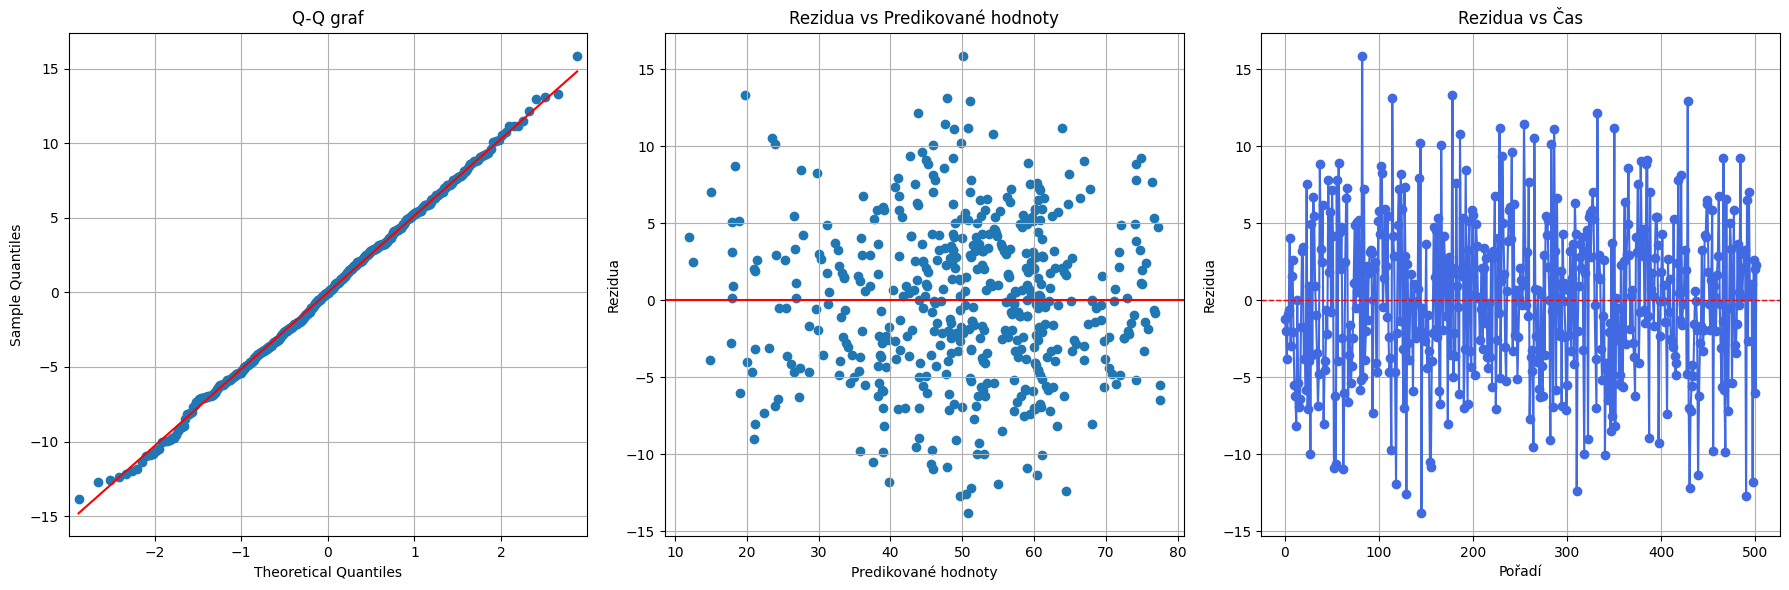

In [590]:
# Výpočet odlehlých hodnot z Cookovi vzdálenosti
cook = results.get_influence().cooks_distance[0]
threshold = 15 / len(results.model.endog)
outliers = np.where(cook > threshold)[0]
print(f"Indexy odlehlých hodnot: {outliers}")
dfs_clean = dfs.drop(index=outliers)

# Přepočítání modelu
f_final = "Ping ~ ActiveUsers + Scroll + C(OSType) + ActiveUsers:Scroll + ActiveUsers:C(OSType) + I(ActiveUsers**2)"
model_clean = smf.ols(formula=f_final, data=dfs_clean)
results_final_clean = model_clean.fit()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
qqplot(results_final_clean.resid, line='s', ax=ax[0])
# Q-Q graf
ax[0].set_title('Q-Q graf')
ax[0].grid(True)
# Rezidua vs. Predikce graf
ax[1].scatter(results_final_clean.fittedvalues, results_final_clean.resid)
ax[1].axhline(y=0, color='r', linestyle='-')
ax[1].grid(True)
ax[1].set_xlabel('Predikované hodnoty')
ax[1].set_ylabel('Rezidua')
ax[1].set_title('Rezidua vs Predikované hodnoty')
# Rezidua vs. Čas graf
ax[2].plot(results_final_clean.resid, marker='o', linestyle='-', color='royalblue')
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=1)
ax[2].grid(True)
ax[2].set_title('Rezidua vs Čas')
ax[2].set_xlabel('Pořadí')
ax[2].set_ylabel('Rezidua')
plt.tight_layout()
plt.show()

In [591]:
print(results_final_clean.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        03:33:39   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Finální rovnice po dosazení:
$$
\begin{align*}
Ping &= 51.2936 + 10.0457 * ActiveUsers -5.1410 * Scroll + 3.6657 * Windows + 9.0073 * MacOS -5.7223 * iOS + 2.5596 * (ActiveUsers*Scroll)\\
&-1.9127 * (ActiveUsers*Windows) + 4.4373 * (ActiveUsers*MacOS) -2.7423 * (ActiveUsers*iOS) -3.0081 * ActiveUsers^2
\end{align*}
$$

Splnění předpokladů regrese:
- Normalita - Víme že data normální jsou podle Q-Q grafu o kousek výše, jelikož leží přímo na přímce.
- Homoskedasticita - Tu jsme schopni ověřit v grafu Reziduí a Predikcí, kde vidíme že data mají v celku různé rozptyly a nemají žádnou očividnou závislost, což je správně.
- Autokorelace - Z grafu Reziduí a Pořadí jsme schopni ověřit, že data nejsou nijak závislá na pořadí nebo čase.

Můžeme tedy usoudit, že základní regresní předpoklady jsou splněny. Splnění těchto předpokladů nám umožňuje považovat výsledky regresní analýzy za spolehlivé a interpretovatelné. Regrese tak poskytuje validní odhad vztahů mezi proměnnými.

### 2)

Nejprve si vygenerujeme si predikovaná data, najdeme maximální hodnotu a tu použijeme na nalezení hodnot konfigurace.

Zároveň nesmíme zapomenout "destanardardizovat" sloupec ActiveUsers a Scroll na puvodní podobnu před standardizací.

In [592]:
predicted = results_final_clean.predict(dfs_clean)
problematic_params = dfs_clean.iloc[predicted.idxmax()].copy()
max_value = predicted[predicted.idxmax()]

# Destandardizace
problematic_params['ActiveUsers'] = problematic_params['ActiveUsers'] * au_std + au_mean
problematic_params['Scroll'] = problematic_params['Scroll'] * sc_std + sc_mean
print("Max predicted ping: ", max_value)
print("\nProblematic parameters: ")
print(problematic_params)


Max predicted ping:  77.50462838943051

Problematic parameters: 
OSType          MacOS
ActiveUsers    9657.0
Scroll          0.027
Ping               72
Name: 10, dtype: object


Nejproblematičtější odezvu má výsledný model pro OSType: MacOS, ActiveUsers: 9657 a Scroll: 0.027.

Maximální predikovaná hodnota odezvy je: 77.504628 ms

### 3)

In [593]:
# Vytvořený průměrné Windows konfigurace
windows_average = pd.DataFrame({
    'ActiveUsers':  [dfs_clean['ActiveUsers'].mean()],
    'Scroll':       [dfs_clean['Scroll'].mean()],
    'OSType':       ['Windows'],
})

# Pořebujeme použít get_prediction abychom měli summary_frame()
predicted = results_final_clean.get_prediction(windows_average)
sum = predicted.summary_frame(alpha=0.05)
print(sum[['mean', 'obs_ci_lower', 'obs_ci_upper', 'mean_ci_lower', 'mean_ci_upper']])


        mean  obs_ci_lower  obs_ci_upper  mean_ci_lower  mean_ci_upper
0  55.002689     44.724693     65.280685      53.972145      56.033232


Výsledné intervaly jsou tedy následující.

Interval spolehlivosti 95%: $<53.9721;56.0332>$

Predikční interval 95%: $<44.7247;65.2807>$

Odhad odezvy uživatele Windows s průměrnými parametry: 55.0027 ms

### 4)
1. R-squred
2. P-values
3. CI and PI
4. Rezidua diagnosis
5. Vliv koeficientů